In [ ]:
!pip install -U bitsandbytes transformers accelerate lime captum

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import sys

path = os.getcwd()
while True:
    if 'utils.py' in os.listdir(path):
        if path not in sys.path:
            sys.path.append(path)
        break
    new_path = os.path.dirname(path)
    if new_path == path:
        upload_utils = files.upload()
        break
    path = new_path

import utils
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

c:\Users\User\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Global Parameters of Notebook
global_params = {'dataset_type': 'scitail',
                'quantization': 'full',
                'training_mode': 'zero shot',
                'model_id': 'Apple/OpenELM-3B-Instruct'}

# Create checkpoint
checkpoint_path = utils.create_checkpoint_path(params=global_params)

Saving to: c:\Users\User\iCloudDrive\Desktop\DAMA_EAP\NLI_Study\Notebooks\Scitail_Notebooks\Scitail_OpenELM_3B_Instruct\Zero-Shot\checkpoint_scitail_OpenELM_3B_Instruct_full_zero_shot.pt


In [ ]:
utils.hf_login("HF_TOKEN")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-hf')
model = AutoModelForCausalLM.from_pretrained(
    global_params['model_id'],
    device_map="auto",
    attn_implementation="eager",
    trust_remote_code=True
    )

# Add padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token

# Change the model to evaluation mode
model.eval()

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_openelm.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Apple/OpenELM-3B-Instruct:
- configuration_openelm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_openelm.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Apple/OpenELM-3B-Instruct:
- modeling_openelm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

OpenELMForCausalLM(
  (transformer): OpenELMModel(
    (token_embeddings): Embedding(32000, 3072)
    (layers): ModuleList(
      (0): OpenELMDecoderLayer(
        (attn): OpenELMMultiHeadCausalAttention(
          query_heads=12, key_heads=3, value_heads=3
          (qkv_proj): Linear(in_features=3072, out_features=2304, bias=False)
          (pos_embedding): OpenELMRotaryEmbedding(	model_dim=128, max_seq_length=4096, freq_constant=10000)
          (q_norm): OpenELMRMSNorm(num_features=128, eps=1e-06)
          (k_norm): OpenELMRMSNorm(num_features=128, eps=1e-06)
          (out_proj): Linear(in_features=1536, out_features=3072, bias=False)
        )
        (ffn): OpenELMFeedForwardNetwork(
          (ffn_with_glu) : True
          (proj_1): Linear(in_features=3072, out_features=3072, bias=False)
          (proj_2): Linear(in_features=1536, out_features=3072, bias=False)
          (act): SiLU()
        )
        (ffn_norm): OpenELMRMSNorm(num_features=3072, eps=1e-06)
        (attn_n

In [ ]:
files.upload()
scitail_test = pd.read_csv('scitail_test.csv')

In [ ]:
scitail_test.info()

In [ ]:
scitail_test.head(10)

In [ ]:
# Find the max_length for tokenization to avoid wasting computing.
utils.find_max_length(scitail_test, tokenizer=tokenizer, dataset_type=global_params['dataset_type'])

In [ ]:
# Define dataset and create a dataloader.
dataset_test = utils.MyDataset(dataframe=scitail_test,
                               tokenizer=tokenizer,
                               dataset_type=global_params['dataset_type'],
                               prompt_max_length=117,
                               label_max_length=3)

batch_size = 16 # Change batch size according to GPU
dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
from importlib import reload
reload(utils)
# Test
predictions, gold_labels, batch_probs = utils.test_run(model=model,
                                          dataloader=dataloader,
                                          tokenizer=tokenizer,
                                          dataset_type=global_params['dataset_type'])

for i, pair in enumerate(zip(predictions, gold_labels)):
    print(pair, batch_probs[i])

past_key_values should not be None in from_legacy_cache()


('neutral', 'neutral') tensor([0.0054, 0.9946], device='cuda:0')
('neutral', 'neutral') tensor([0.0063, 0.9938], device='cuda:0')
('neutral', 'neutral') tensor([0.0058, 0.9942], device='cuda:0')
('neutral', 'neutral') tensor([5.1588e-04, 9.9948e-01], device='cuda:0')
('neutral', 'neutral') tensor([0.0056, 0.9944], device='cuda:0')
('neutral', 'neutral') tensor([0.0017, 0.9983], device='cuda:0')
('neutral', 'entails') tensor([0.0059, 0.9941], device='cuda:0')
('neutral', 'entails') tensor([0.0069, 0.9931], device='cuda:0')
('neutral', 'entails') tensor([0.0020, 0.9980], device='cuda:0')
('neutral', 'neutral') tensor([0.0107, 0.9893], device='cuda:0')
('neutral', 'neutral') tensor([0.0038, 0.9962], device='cuda:0')
('neutral', 'neutral') tensor([0.0019, 0.9981], device='cuda:0')
('neutral', 'entails') tensor([0.0036, 0.9964], device='cuda:0')
('neutral', 'neutral') tensor([0.0035, 0.9965], device='cuda:0')
('neutral', 'neutral') tensor([0.0032, 0.9968], device='cuda:0')
('neutral', 'neut

In [ ]:
from tqdm import tqdm

# Load checkpoint if it exists
predicted_labels, gold_labels, start_batch = utils.load_checkpoint(checkpoint_path=checkpoint_path)
labels = utils.get_labels(global_params['dataset_type'])

# Loop over the batches
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader, desc="Evaluating", unit="batch")):

        # Continue from last checkpoint
        if i < start_batch:
            continue

        input_ids_batch = batch["input_ids"].to(model.device) # Move to GPU
        attention_mask_batch = batch["attention_mask"].to(model.device) # Move to GPU
        gold_labels_batch = batch["labels"] # Keep to CPU

        batch_probs = utils.get_model_probs(batch_input_ids=input_ids_batch,
                                      batch_attention_mask=attention_mask_batch,
                                      dataset_type=global_params['dataset_type'],
                                      model=model,
                                      tokenizer=tokenizer)

        # Try to catch NaN values
        if torch.isnan(batch_probs).any():
            print("Warning: NaNs detected in batch_probs")

        batch_pred_indices = torch.argmax(batch_probs, dim=1)
        batch_pred_labels = [labels[i] for i in batch_pred_indices]

        predicted_labels.extend(batch_pred_labels)
        gold_labels.extend(gold_labels_batch)

        # Save checkpoint
        if i % 50 == 0 or i == len(dataloader) - 1:
            torch.save({"predicted_labels": predicted_labels,
                        "gold_labels": gold_labels,
                        "batch_no": i+1}, checkpoint_path)

            print(f"Checkpoint saved: {i+1}, {checkpoint_path}")

Checkpoint found.


Evaluating:  38%|███▊      | 51/133 [10:15<16:47, 12.29s/batch]

Checkpoint saved: 51, /content/drive/MyDrive/eval_checkpoints/checkpoint_scitail_OpenELM_3B_Instruct.pt


Evaluating:  76%|███████▌  | 101/133 [20:29<06:33, 12.29s/batch]

Checkpoint saved: 101, /content/drive/MyDrive/eval_checkpoints/checkpoint_scitail_OpenELM_3B_Instruct.pt


Evaluating: 100%|██████████| 133/133 [27:01<00:00, 12.19s/batch]

Checkpoint saved: 133, /content/drive/MyDrive/eval_checkpoints/checkpoint_scitail_OpenELM_3B_Instruct.pt


Checkpoint found.
Accuracy: 0.6002.
 F1 Score: 0.3794.
 Matthew's Correlation Coefficient: -0.0260.
 Cohen's Kappa Score: -0.0055.


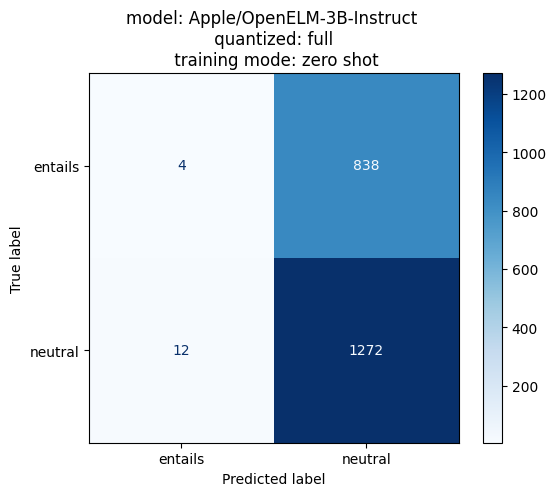

In [4]:
# Calculate metrics
predicted_labels, gold_labels, _ = utils.load_checkpoint(checkpoint_path)
utils.evaluate_metrics(predicted_labels=predicted_labels, gold_labels=gold_labels, params=global_params)